# 3D Slicer w/ Jupyter Notebooks Tutorial - 04/12/2020 MPHY0030

## *Part 0 - Installation and Introduction*

### Overview

This notebook provides an overview and introduction to 3D Slicer Notebooks with Jupyter, and will be the main content for what is discussed and gone through in class.

Installation instructions for 3D Slicer and Jupyter Notebooks are contained here, and within the pre-recorded lecture video.

### Installing 3D Slicer

Head to [download.slicer.org](https://download.slicer.org/), and make sure to install the Stable Release for your platform (Windows, Mac, Linux).

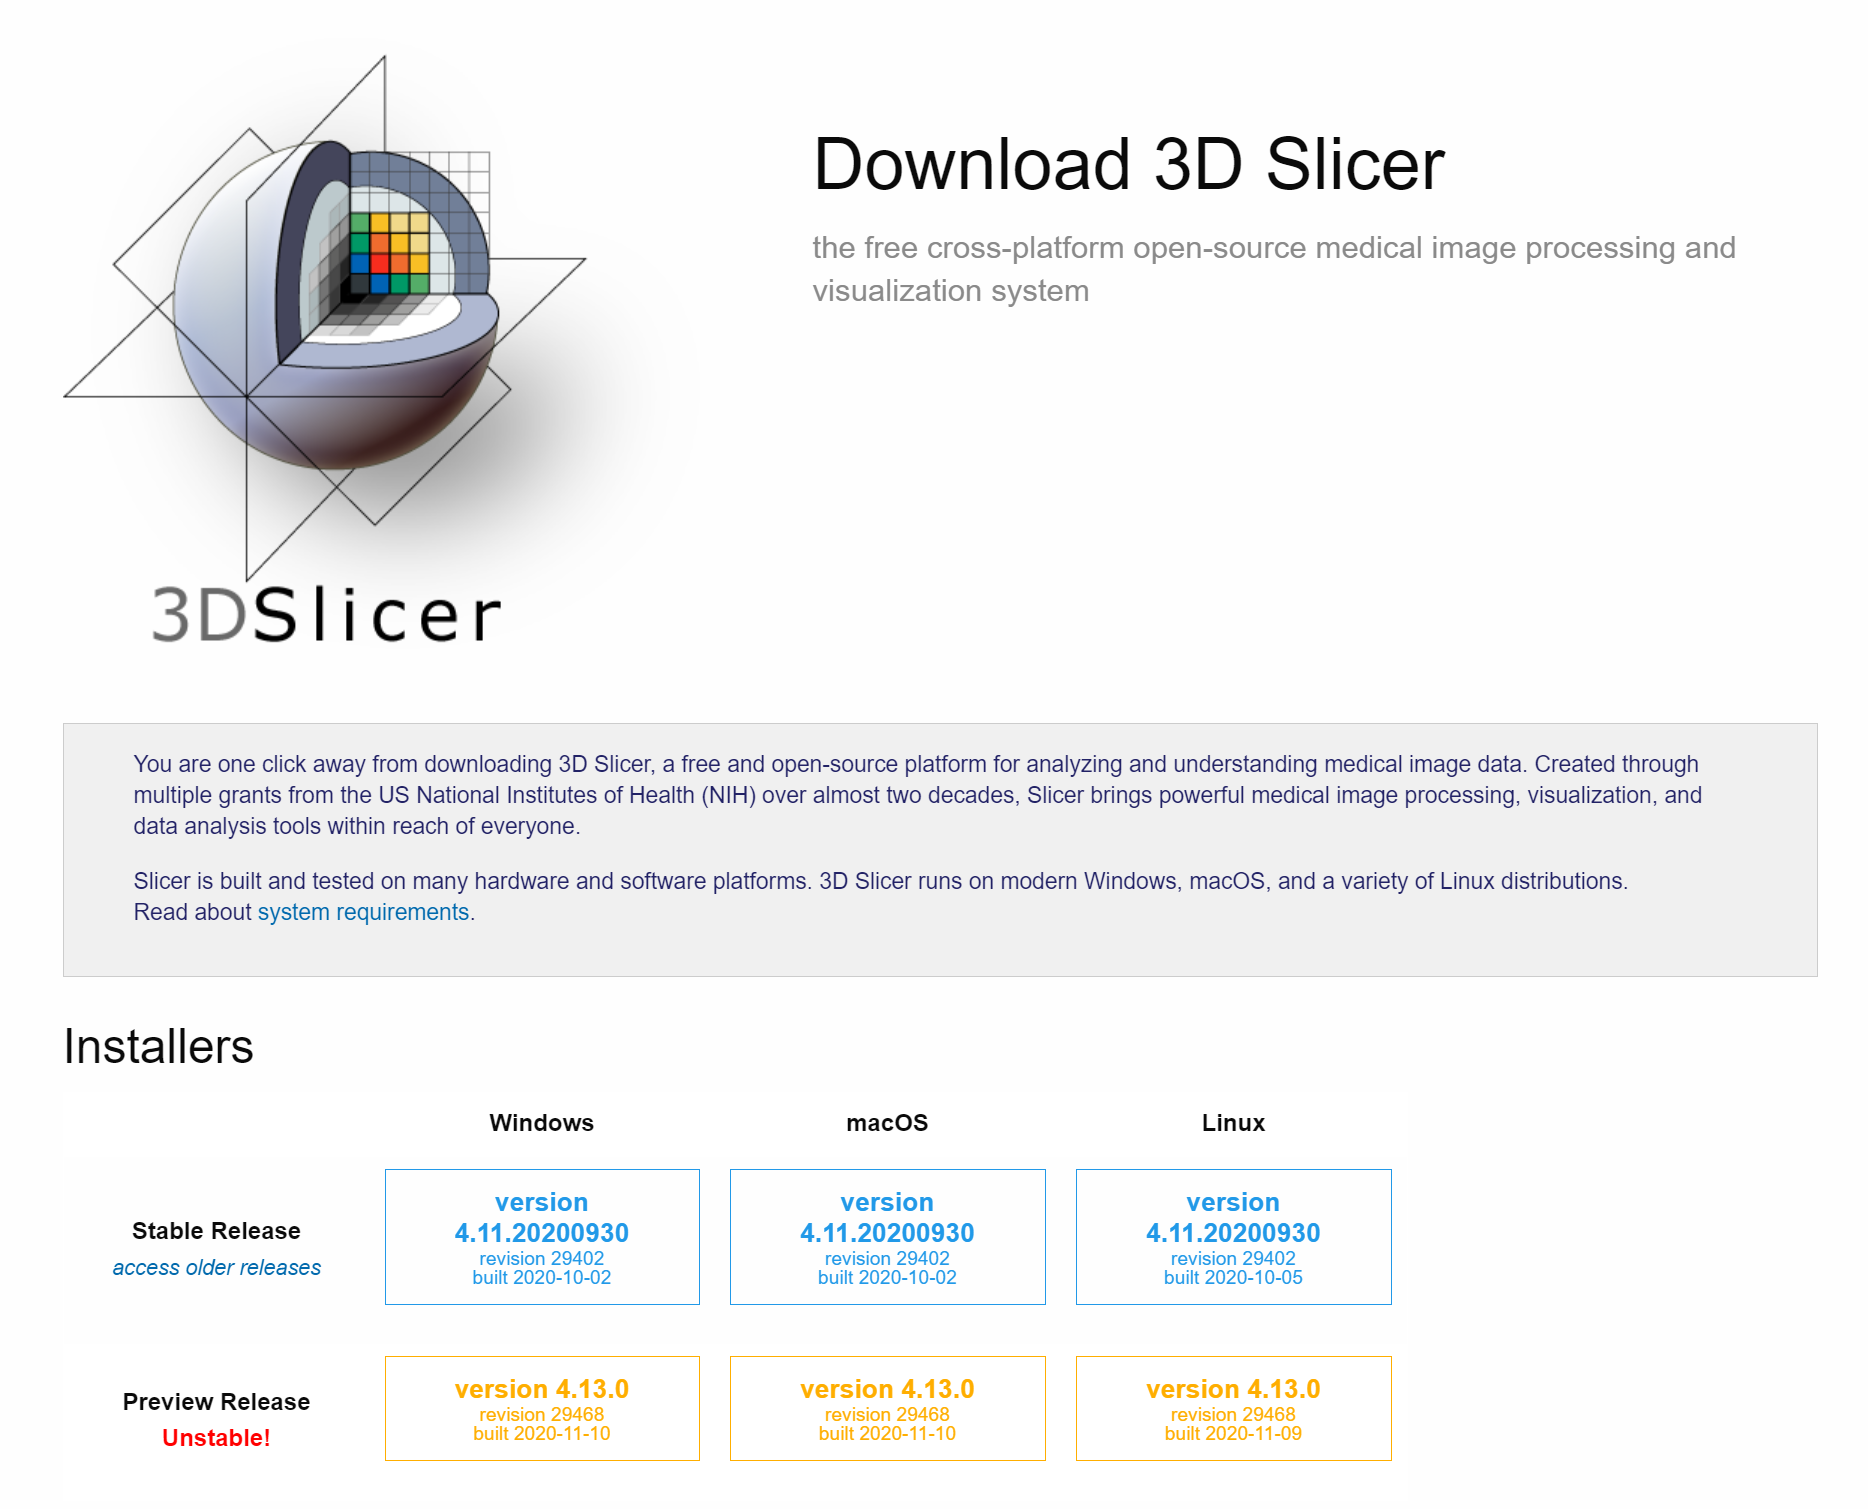

Once installed, Open the Extension Manager and install the Jupyter Notebooks extension. Once that's done, make sure to restart 3D Slicer.

### Installing Jupyter Notebooks

After 3D Slicer restarts, open the JupyterKernel "module". You can do this by searching for it (click the magnifying glass icon) or selecting the module dropdown and going into `Developer Tools > JupyterKernel`.

Next, simply click the "Start Jupyter Server" button and wait a few minutes. 3D Slicer will take care of setting up an environment, and installing any/all required packages for you. Just be patient here - 3D Slicer may lock up and "Not Respond", but it will free up after a few minutes.

You'll know its done when your default internet browser opens a new Window that looks like this:

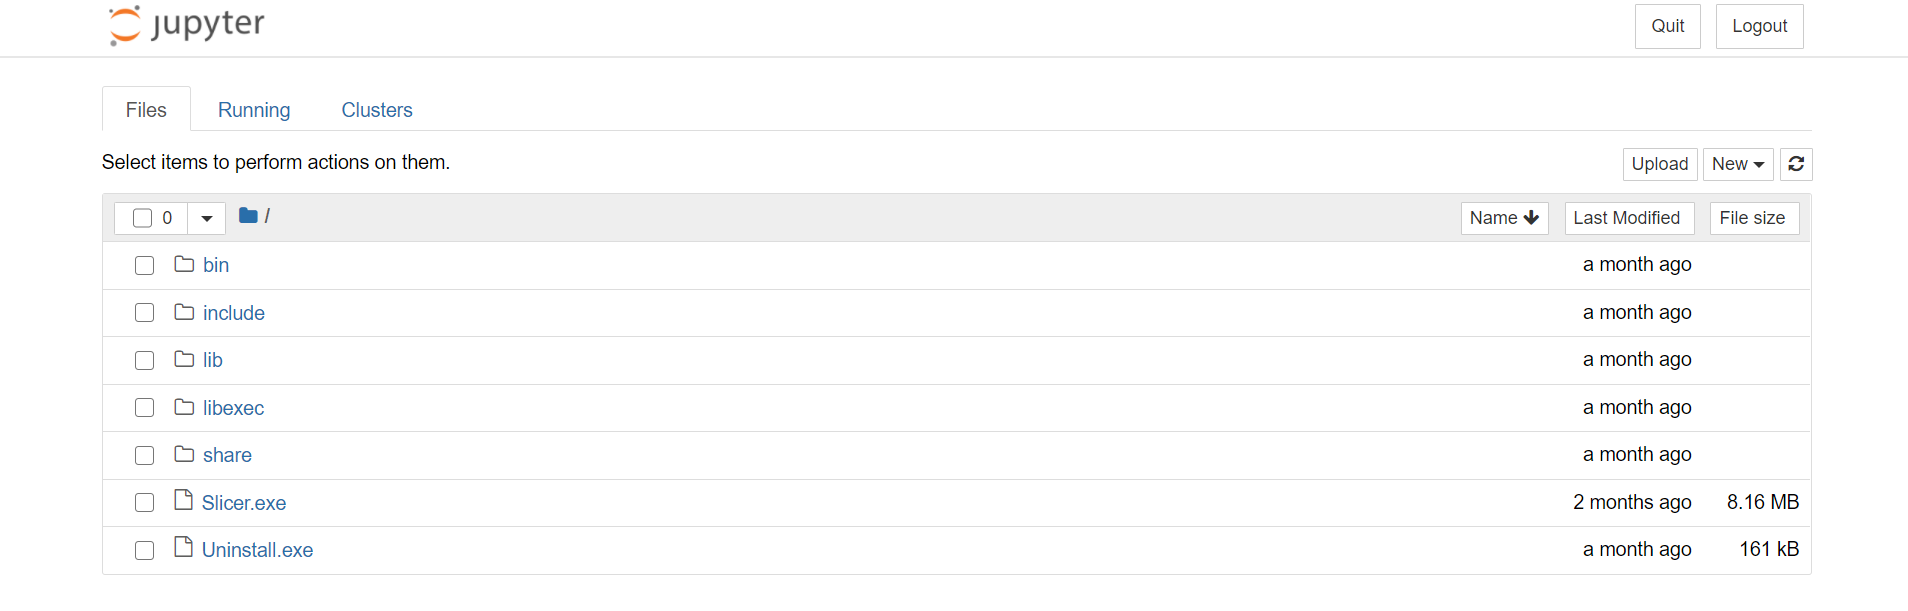

From there, you'll want to "upload" this notebook and then you'll be ready to get started!

## *Part 1 - Data Loading & Visualizations*

In 3D Slicer, you would traditionally use the user interface to interact with, and manipulate any images or data that you have. You can do all that (and more!) with Jupyter Notebooks and some Python programming.

Let's start by downloading a Brain MRI Series, and displaying the size of the image, before displaying it.

In [3]:
import JupyterNotebooksLib as slicernb

# Set image viewer size to 75% (fill 3/4s of a cell)
slicernb.AppWindow.setWindowSize(scale=0.75)
# Hide patient information from slice view
slicernb.showSliceViewAnnotations(False)

# Clear scene
slicer.mrmlScene.Clear(False)

# Load a Slicer sample data set
import SampleData
volume = SampleData.SampleDataLogic().downloadMRBrainTumor1()

print("Volume size: {0}".format(volume.GetImageData().GetDimensions()))

Volume size: (256, 256, 112)


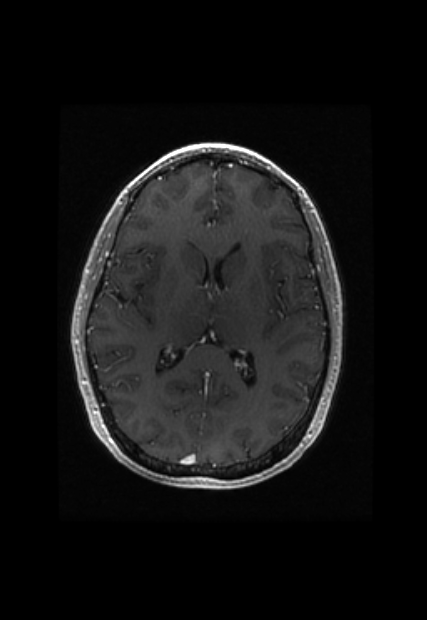

In [4]:
# Show slice view
slicernb.ViewDisplay("OneUpRedSlice")

Now let's take a look at that same image, in a "lightbox" view, where we see multiple images at a time.

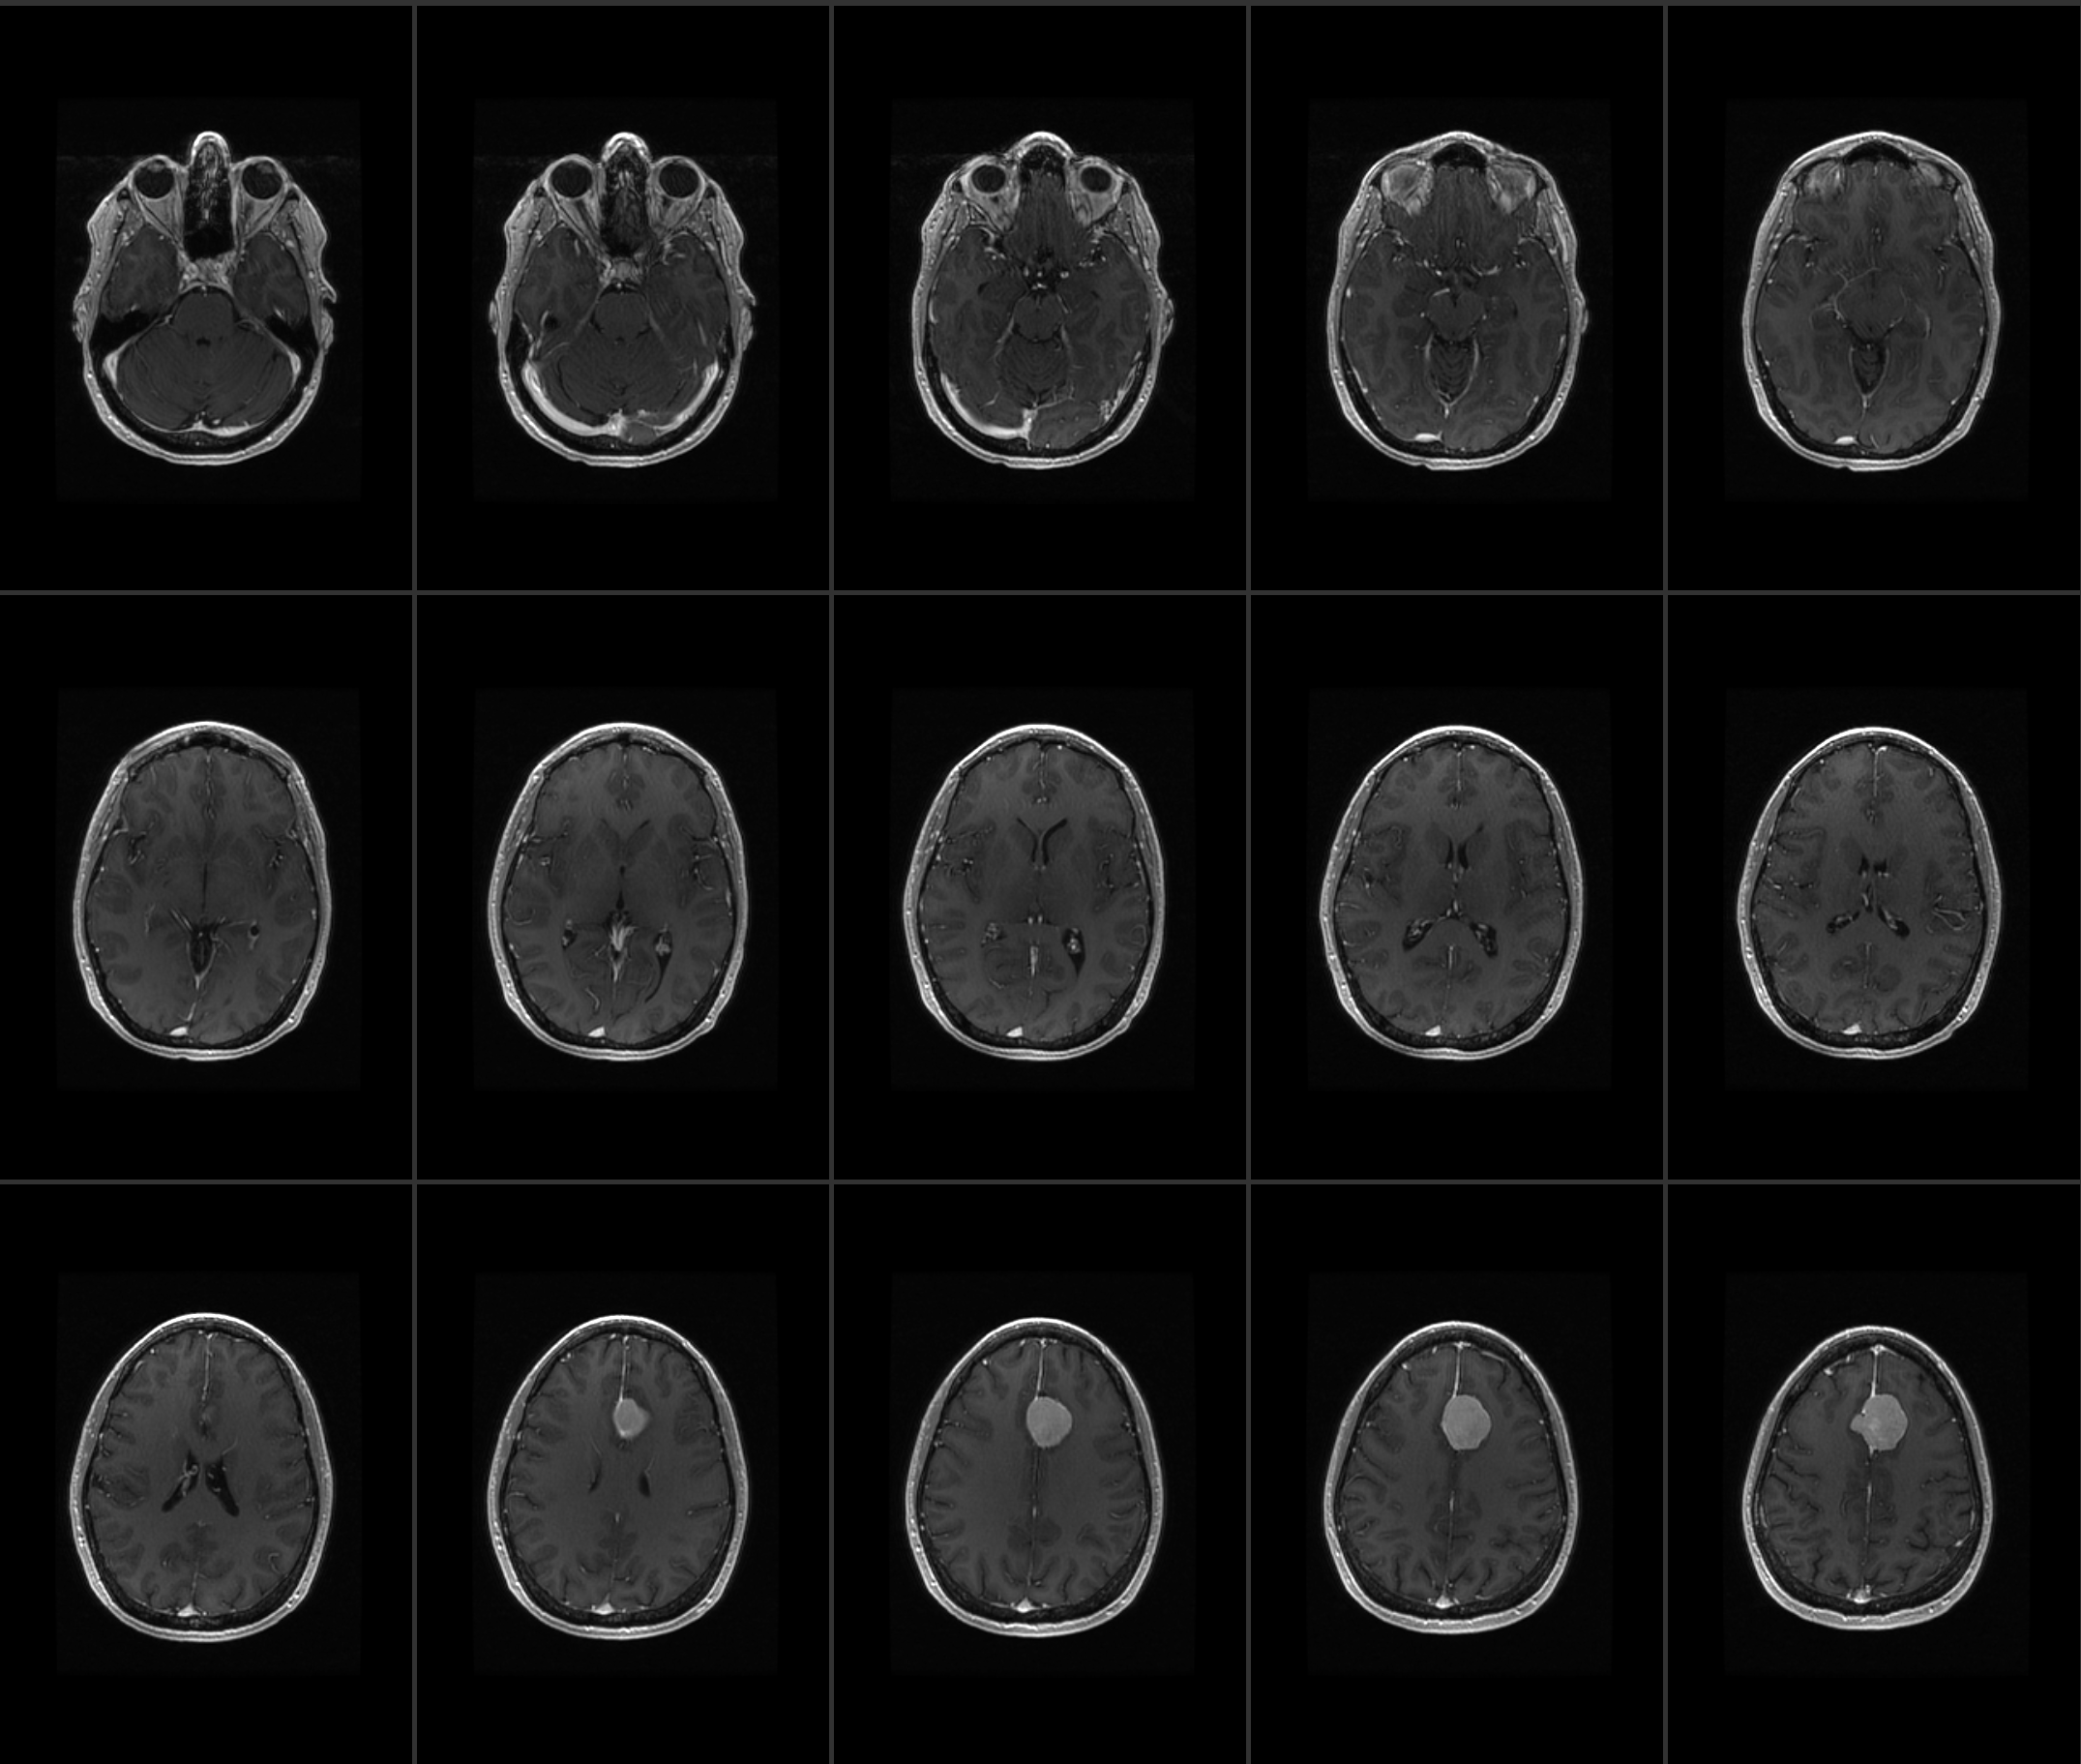

In [5]:
# Lightbox view
slicernb.ViewLightboxDisplay("Red", columns=5, rows=3, rangeShrink=[45,50])

One last thing to try before we more on - let's show the volume from other slice views (Sagittal and Coronal planes) and render the MRI image in 3D as a volume.

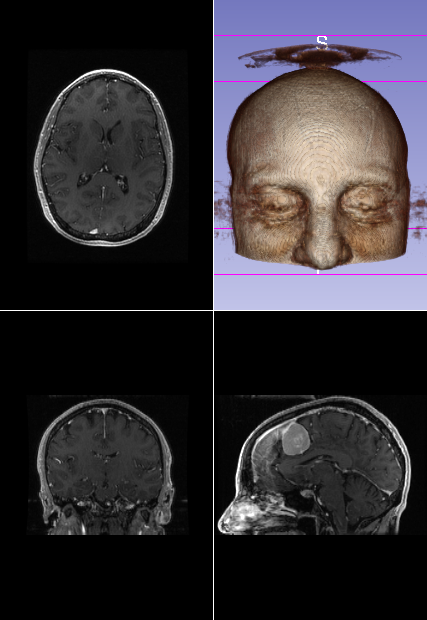

In [6]:
# Enable 3D volume rendering
slicernb.showVolumeRendering(volume)

# Show slice and 3D views
slicernb.ViewDisplay("FourUp")  # You can also try: FourUp, OneUpRedSlice, OneUp3D

Some caveats to using Notebooks vs. 3D slicer here when we just use regular widgets...
* Displayed content is saved in the notebook, even when you restart, these images will persist (until updated)
* Low update rate, whereas 3D Slicer is always "live"
* Mouse and keyboard events are not captured

However, we can still use some dynamic widgets to adjust the viewers as we please in "real-time"...

Let's try re-slicing the image in the Axial plane.

In [7]:
# Slice view display
from ipywidgets import interact
@interact(position=(0,100))
def update(position=50):
    return slicernb.ViewSliceDisplay('Red', positionPercent=position)

interactive(children=(IntSlider(value=50, description='position'), Output()), _dom_classes=('widget-interact',…

We can do the same with the 3D volume from before... Now what happens if we adjust the display angles (roll, pitch, and yaw) and crop the width, height, and length of the image displayed?

In [8]:
# Enable volume cropping
displayNode = slicer.modules.volumerendering.logic().GetFirstVolumeRenderingDisplayNode(volume)
displayNode.SetCroppingEnabled(True)
roiNode = displayNode.GetROINode()

# 3D view display
slicernb.reset3DView()
from ipywidgets import interact
@interact(roll=(-90.0,90.0,5), pitch=(-90.0,90.0,5), yaw=(-180.0,180.0,5), cropx=(0,70,5), cropy=(0,120,5), cropz=(0, 80, 5))
def update(roll=0, pitch=0, yaw=0, cropx=70, cropy=120, cropz=80):
    roiNode.SetRadiusXYZ([cropx, cropy, cropz])
    return slicernb.View3DDisplay(0, orientation=[roll, pitch, yaw])

interactive(children=(FloatSlider(value=0.0, description='roll', max=90.0, min=-90.0, step=5.0), FloatSlider(v…

These "View Widgets" can also be concatenated together to have multiple views at once.

In [9]:
# Slice widgets
from ipywidgets import HBox
display(HBox([slicernb.ViewSliceWidget('Red'), slicernb.ViewSliceWidget('Yellow'), slicernb.ViewSliceWidget('Green')]))

In [10]:
# 3D widget
display(HBox([slicernb.ViewSliceBaseWidget('Red', width="40%"), slicernb.View3DWidget(0, width="40%")]))

We can also track the mouse actions and keyboard events if we want to in "interactive widgets". Try it out below!

In [11]:
# Adjust maximum rate of Slicer's Jupyter kernel consuming Jupyter messages.
# Lower values make the notebook more responsive but too low values may make the Slicer application
# slow to respond.
slicer.modules.jupyterkernel.setPollIntervalSec(0.001)

# 3D view
slicernb.AppWindow.setWindowSize(scale=0.75)
live3d = slicernb.ViewInteractiveWidget('1')
live3d.trackMouseMove = True
display(live3d)

ViewInteractiveWidget(height=295, width=213)

In [12]:
# Slice view (use arrow keys to move between slices, right-click-and-drag to zoom in/out)
liveRedSlice = slicernb.ViewInteractiveWidget('R')
liveRedSlice.trackMouseMove = True
display(liveRedSlice)

ViewInteractiveWidget(height=295, width=213)

## *Part 2 - Data Processing*

In 3D Slicer, you can make use of many different thresholding, filtering, smoothing methods to process images.

You can affect individual image slices, and entire surfaces/meshes.

Let's try that on a new dataset; an abdominal CT scan. First, thresholding:

In [13]:
# Print all parameters of a CLI module to see what options we have...
cliModule = slicer.modules.thresholdscalarvolume
n=cliModule.cliModuleLogic().CreateNode()
for groupIndex in range(n.GetNumberOfParameterGroups()):
  for parameterIndex in range(n.GetNumberOfParametersInGroup(groupIndex)):
    print('Parameter ({0}/{1}): {2} ({3})'.format(groupIndex, parameterIndex, n.GetParameterName(groupIndex, parameterIndex), n.GetParameterLabel(groupIndex, parameterIndex)))

Parameter (0/0): InputVolume (Input Volume)
Parameter (0/1): OutputVolume (Output Volume)
Parameter (1/0): ThresholdType (Threshold Type)
Parameter (1/1): ThresholdValue (Threshold Value)
Parameter (1/2): Lower (Lower)
Parameter (1/3): Upper (Upper)
Parameter (1/4): OutsideValue (Outside Value)
Parameter (1/5): Negate (Negate Threshold)


In [14]:
import JupyterNotebooksLib as slicernb

# Clear scene
slicer.mrmlScene.Clear(False)

import SampleData
volume = SampleData.SampleDataLogic().downloadCTChest()

# Create output node
blurredVolume = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLScalarVolumeNode", "Filtered")
blurredVolume.CreateDefaultDisplayNodes()

# Show 3-over-3 compare layout with original and blurred volume
slicernb.showSliceViewAnnotations(True)
slicernb.setViewLayout("ThreeOverThree")
layoutManager = slicer.app.layoutManager()
for sliceViewName in layoutManager.sliceViewNames():
    sliceWidget = layoutManager.sliceWidget(sliceViewName)
    volumeNodeToShow = volume if sliceWidget.mrmlSliceNode().GetViewGroup() == 0  else blurredVolume
    sliceWidget.mrmlSliceCompositeNode().SetBackgroundVolumeID(volumeNodeToShow.GetID())

slicernb.showSliceViewAnnotations(False)
    
# Create a function for performing the filtering.
# This will be executed whenever the slider is moved and released.
def threshold(lower=-20, upper=180):
    parameters = {
        "InputVolume": volume.GetID(),
        "OutputVolume": blurredVolume.GetID(),
        "Lower": lower,
        "Upper": upper
        }
    slicer.cli.runSync(slicer.modules.thresholdscalarvolume, parameters=parameters, update_display=False)
    return slicernb.ViewDisplay("ThreeOverThree")

# Create slider
from ipywidgets import FloatSlider, interact
i=interact(threshold,
         lower=FloatSlider(250, min=-250, max=750, step=5, continuous_update=False),
         upper=FloatSlider(750, min=-250, max=750, step=5, continuous_update=False))

interactive(children=(FloatSlider(value=250.0, continuous_update=False, description='lower', max=750.0, min=-2…

Next, we can use an isotropic Gaussian blur to, well, blur the images:

In [15]:
# Print all parameters of a CLI module to see what options we have...
cliModule = slicer.modules.gaussianblurimagefilter
n=cliModule.cliModuleLogic().CreateNode()
for groupIndex in range(n.GetNumberOfParameterGroups()):
  for parameterIndex in range(n.GetNumberOfParametersInGroup(groupIndex)):
    print('Parameter ({0}/{1}): {2} ({3})'.format(groupIndex, parameterIndex, n.GetParameterName(groupIndex, parameterIndex), n.GetParameterLabel(groupIndex, parameterIndex)))

Parameter (0/0): sigma (Sigma)
Parameter (0/1): inputVolume (Input Volume)
Parameter (0/2): outputVolume (Output Volume)


In [16]:
# Create output node
blurredVolume = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLScalarVolumeNode", "Filtered")
blurredVolume.CreateDefaultDisplayNodes()

# Show 3-over-3 compare layout with original and blurred volume
slicernb.showSliceViewAnnotations(True)
slicernb.setViewLayout("ThreeOverThree")
layoutManager = slicer.app.layoutManager()
for sliceViewName in layoutManager.sliceViewNames():
    sliceWidget = layoutManager.sliceWidget(sliceViewName)
    volumeNodeToShow = volume if sliceWidget.mrmlSliceNode().GetViewGroup() == 0  else blurredVolume
    sliceWidget.mrmlSliceCompositeNode().SetBackgroundVolumeID(volumeNodeToShow.GetID())

slicernb.showSliceViewAnnotations(False)

# Create a function for performing the filtering.
# This will be executed whenever the slider is moved and released.
def blur(sigma=1):
    parameters = {
        "inputVolume": volume.GetID(),
        "outputVolume": blurredVolume.GetID(),
        "sigma": sigma,
        }
    slicer.cli.runSync(slicer.modules.gaussianblurimagefilter, parameters=parameters, update_display=False)
    return slicernb.ViewDisplay("ThreeOverThree")

# Create slider
from ipywidgets import FloatSlider, interact
i=interact(blur, sigma=FloatSlider(5, min=0, max=10, step=1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='sigma', max=10.0, step=1.0)…

We can also perform operations on an entire volume, or rather on the model which we reconstruct from that volume:

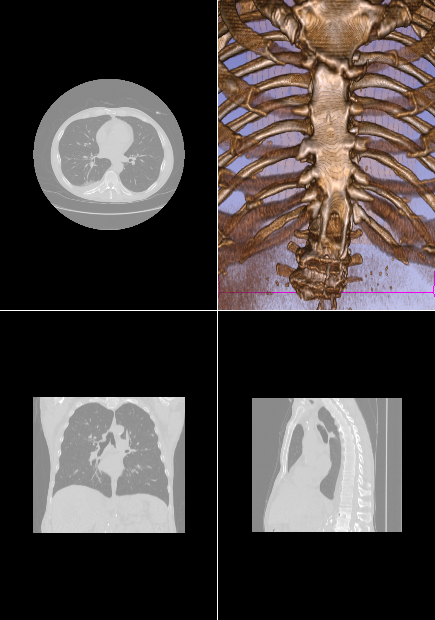

In [17]:
# Volume render a small (75%) image
slicernb.AppWindow.setWindowSize(scale=0.75)
slicernb.showVolumeRendering(volume)
slicernb.showSliceViewAnnotations(False)

display(slicernb.ViewDisplay("FourUp"))

# Disable volume rendering to make sure it does not slow down execution
slicernb.showVolumeRendering(volume, False)

In [18]:
# Print all parameters of a CLI module to see what options we have...
cliModule = slicer.modules.grayscalemodelmaker
n=cliModule.cliModuleLogic().CreateNode()
for groupIndex in range(n.GetNumberOfParameterGroups()):
  for parameterIndex in range(n.GetNumberOfParametersInGroup(groupIndex)):
    print('Parameter ({0}/{1}): {2} ({3})'.format(groupIndex, parameterIndex, n.GetParameterName(groupIndex, parameterIndex), n.GetParameterLabel(groupIndex, parameterIndex)))

Parameter (0/0): InputVolume (Input Volume)
Parameter (0/1): OutputGeometry (Output Geometry)
Parameter (1/0): Threshold (Threshold)
Parameter (1/1): Name (Model Name)
Parameter (1/2): Smooth (Smooth)
Parameter (1/3): Decimate (Decimate)
Parameter (1/4): SplitNormals (Split Normals?)
Parameter (1/5): PointNormals (Compute Point Normals?)
Parameter (2/0): Debug (Debug)


In [20]:
# Interactive CLI module execution (with progress reporting)

parameters = {}
parameters["InputVolume"] = volume.GetID()
outModel = slicer.vtkMRMLModelNode()
slicer.mrmlScene.AddNode( outModel )
parameters["OutputGeometry"] = outModel.GetID()
grayMaker = slicer.modules.grayscalemodelmaker

from ipywidgets import interact_manual
@interact_manual(threshold=(-500.0,1200,5), smooth=(0,50,1), decimate=(0, 1, 0.05))
def h(threshold=300, smooth=0, decimate=0.05):
    parameters["Threshold"] = threshold
    parameters["Smooth"] = smooth
    parameters["Decimate"] = decimate
    slicernb.cliRunSync(grayMaker, None, parameters)
    return slicernb.ModelDisplay(outModel, orientation=[0,-90,0])

interactive(children=(FloatSlider(value=300.0, description='threshold', max=1200.0, min=-500.0, step=5.0), Int…

You can also use [SimpleITK](https://simpleitk.org/) filters for image processing. Let's try that with our current head MRI images again, but using SimpleITK images instead of built-in Slicer data.

*Make sure you have added the data folder to your Jupyter Notebook folder before trying this!*

In [21]:
import SimpleITK as sitk
import sitkUtils as su

# Clear scene
slicer.mrmlScene.Clear(False)

# Load 3D image using SimpleITK
reader = sitk.ImageFileReader()
reader.SetFileName("tutorial_data/MRBrainTumor1.nrrd")
image = reader.Execute()

Just because we are using SITK for the filtering and processing, doesn't mean that we can't still visualize things in 3D Slicer. You can see all the filtering options within the [SimpleITK documentation](https://simpleitk.readthedocs.io/en/v1.2.4/Documentation/docs/source/filters.html), there are over 250 different filters so make sure to try a few out on your own!

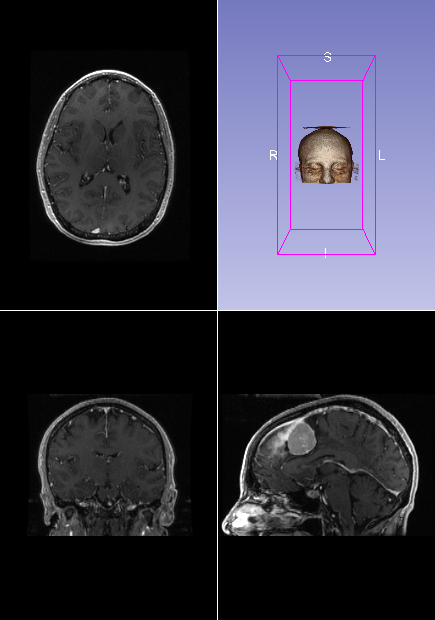

In [22]:
volumeNode = su.PushVolumeToSlicer(image)

# Prevent automatic brightness/contrast update to make the processed images easier to compare
volumeNode.GetDisplayNode().SetAutoWindowLevel(False)

# Set up view layout
slicer.app.layoutManager().setLayout(slicer.vtkMRMLLayoutNode.SlicerLayoutFourUpView)
# Set up slice views
slicer.util.setSliceViewerLayers(background=volumeNode, fit=True)
# Set up volume rendering
displayNode = slicer.modules.volumerendering.logic().CreateDefaultVolumeRenderingNodes(volumeNode)
displayNode.GetVolumePropertyNode().Copy(slicer.modules.volumerendering.logic().GetPresetByName('MR-Default'))
slicer.util.resetThreeDViews()

# Display views
slicernb.ViewDisplay()

Starting with a Gaussian blur...

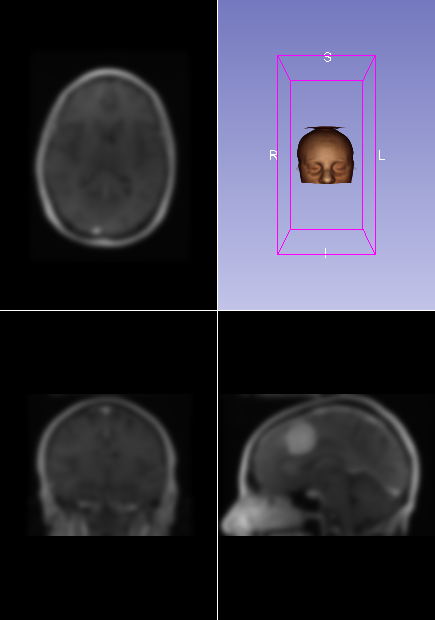

In [23]:
blurFilter = sitk.SmoothingRecursiveGaussianImageFilter()
blurFilter.SetSigma(3.0)
blurredImage = blurFilter.Execute(image)

su.PushVolumeToSlicer(blurredImage, targetNode=volumeNode)
slicernb.ViewDisplay()

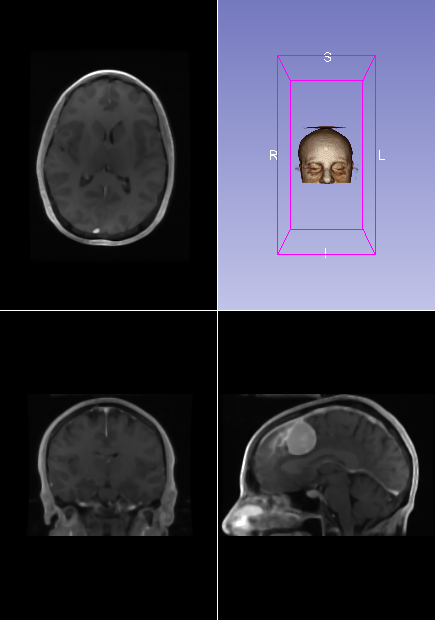

In [24]:
blurFilter2 = sitk.CurvatureFlowImageFilter()
blurFilter2.SetNumberOfIterations(5)
blurFilter2.SetTimeStep(0.25)
blurredImage2 = blurFilter2.Execute(image)

su.PushVolumeToSlicer(blurredImage2, targetNode=volumeNode)
slicernb.ViewDisplay()